In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
def get_diffusion_betas(spec, device):
    """Get betas from the hyperparameters."""
    
    if spec['type'] == 'linear':
        # Used by Ho et al. for DDPM, https://arxiv.org/abs/1006.11239.
        # To be used with Gaussian diffusion models in continuous and discrete
        # state spaces.
        # To be used with transition_mat_type = 'gaussian'
        return torch.linspace(spec['start'], spec['stop'], spec['num_timesteps']).to(device)
    elif spec['type'] == 'cosine':
        # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
        # To be used with transition_mat_type = 'uniform'.
        steps = torch.linspace(0, 1, spec['num_timesteps'] + 1, dtype=torch.float64)
        alpha_bar = torch.square(torch.cos(((steps + 0.008) / 1.008) * torch.pi / 2))
        betas = torch.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], torch.tensor(0.999))
        return betas.to(device)
    elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
        # To be used with absorbing state models.
        # ensures that the probability of decaying to the absorbing state
        # increases linearly over time, and is 1 for t = T-1 (the final time).
        # To be used with transition_mat_type = 'absorbing'
        return 1. / torch.linspace(spec['num_timesteps'], 1, spec['num_timesteps']).to(device)
    else:
        raise NotImplementedError(spec['type'])
    
    
def _get_gaussian_transition_mat(t):
    r"""Computes transition matrix for q(x_t|x_{t-1}).

    This method constructs a transition matrix Q with
    decaying entries as a function of how far off diagonal the entry is.
    Normalization option 1:
    Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                1 - \sum_{l \neq i} Q_{il}  if i==j.
                0                          else.

    Normalization option 2:
    tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                        0                        else.

    Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

    Args:
        t: timestep. integer scalar (or numpy array?)

    Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
    """
    num_classes = 2
    device = 'cpu'
    transition_bands = 1
    spec = {'type': 'linear', 'start': 0.4, 'stop': 1.0, 'num_timesteps': T}
    betas = get_diffusion_betas(spec, device=device)
    transition_bands = transition_bands if transition_bands else num_classes - 1

    beta_t = betas[t]

    mat = torch.zeros((num_classes, num_classes),
                    dtype=torch.float64).to(device, non_blocking=True)

    # Make the values correspond to a similar type of gaussian as in the
    # gaussian diffusion case for continuous state spaces.
    values = torch.linspace(torch.tensor(0.), torch.tensor(num_classes-1), num_classes, dtype=torch.float64).to(device, non_blocking=True)
    #print(values)   # [0, 1]
    values = values * 2./ (num_classes - 1.)
    #print(values)   # [0, 2]
    values = values[:transition_bands+1]
    #print(values)   # [0, 2]
    values = -values * values / beta_t
    #print(values)   # [0, -6300]
    
    # To reverse the tensor 'values' starting from the second element
    reversed_values = values[1:].flip(dims=[0])
    #print(reversed_values)  # [-6300]
    # Concatenating the reversed values with the original values
    values = torch.cat([reversed_values, values], dim=0)
    #print(values)   # [-6300, 0, -6300]
    values = F.softmax(values, dim=0)
    #print(values)   # [0, 1, 0]
    values = values[transition_bands:]
    #print(values)   # [1, 0]
    
    for k in range(1, transition_bands + 1):
        off_diag = torch.full((num_classes - k,), values[k], dtype=torch.float64).to(device, non_blocking=True)

        mat += torch.diag(off_diag, k)
        mat += torch.diag(off_diag, -k)

    # Add diagonal values such that rows and columns sum to one.
    # Technically only the ROWS need to sum to one
    # NOTE: this normalization leads to a doubly stochastic matrix,
    # which is necessary if we want to have a uniform stationary distribution.
    diag = 1. - mat.sum(dim=1)
    mat += torch.diag_embed(diag)

    return mat.to(device, non_blocking=True)

def _get_prior_distribution_transition_mat(t):
        """Computes transition matrix for q(x_t|x_{t-1}).
        Use cosine schedule for these transition matrices.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        device = 'cpu'
        spec = {'type': 'cosine', 'start': 0.4, 'stop': 0.8, 'num_timesteps': T}
        betas = get_diffusion_betas(spec, device=device)
        beta_t = betas[t]
        num_classes = 2
        class_probs = torch.tensor([1 - 5/11000, 5/11000], device=device)
        mat = torch.zeros((num_classes, num_classes), dtype=torch.float64).to(device, non_blocking=True)

        '''for i in range(num_classes):
            for j in range(num_classes):
                if i != j:
                    mat[i, j] = beta_t * class_probs[j]
                else:
                    mat[i, j] = 1 - beta_t + beta_t * class_probs[j]'''
        mat = beta_t * class_probs + (1 - beta_t) * torch.eye(2, device=device)
        
        return mat


q_one_step_mats = [_get_gaussian_transition_mat(t)
                            for t in range(0, T)]
q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to('cpu', non_blocking=True)
assert q_onestep_mats.shape == (T,
                                    2,
                                    2)

# Construct transition matrices for q(x_t|x_start)
q_mat_t = q_onestep_mats[0]
q_mats = [q_mat_t]
for t in range(1, T):
    # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
    q_mat_t = torch.tensordot(q_mat_t, q_onestep_mats[t],
                            dims=[[1], [0]])
    q_mats.append(q_mat_t)
q_mats = torch.stack(q_mats, axis=0)

for t in range(0, T, 9):
    print(q_mats[t])
    # print(_get_gaussian_transition_mat(t))
    # print(_get_prior_distribution_transition_mat(t))

'''import matplotlib.pyplot as plt

spec = {'type': 'linear', 'start': 1.0, 'stop': 100.0, 'num_timesteps': 100}
betas = get_diffusion_betas(spec, device='cpu')
plt.plot(betas)
plt.show()'''

tensor([[9.9995e-01, 4.5396e-05],
        [4.5396e-05, 9.9995e-01]], dtype=torch.float64)
tensor([[0.9982, 0.0018],
        [0.0018, 0.9982]], dtype=torch.float64)
tensor([[0.9897, 0.0103],
        [0.0103, 0.9897]], dtype=torch.float64)
tensor([[0.9649, 0.0351],
        [0.0351, 0.9649]], dtype=torch.float64)
tensor([[0.9140, 0.0860],
        [0.0860, 0.9140]], dtype=torch.float64)
tensor([[0.8348, 0.1652],
        [0.1652, 0.8348]], dtype=torch.float64)


"import matplotlib.pyplot as plt\n\nspec = {'type': 'linear', 'start': 1.0, 'stop': 100.0, 'num_timesteps': 100}\nbetas = get_diffusion_betas(spec, device='cpu')\nplt.plot(betas)\nplt.show()"

In [5]:
e_marginals = torch.tensor([0.9, 0.1], dtype=torch.float64)
print(e_marginals.unsqueeze(0).expand(2, -1).unsqueeze(0))

tensor([[[0.9000, 0.1000],
         [0.9000, 0.1000]]], dtype=torch.float64)


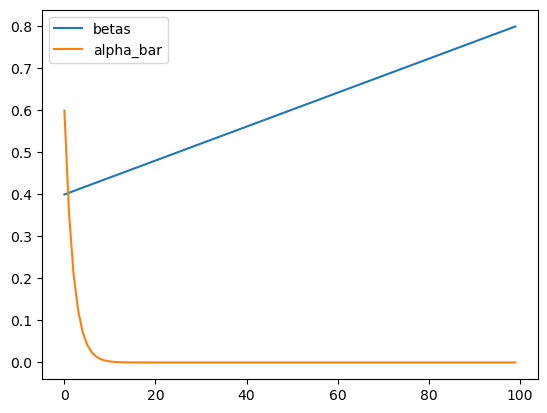

[0. 1.]
[0. 2.]
[0. 2.]
[-0. -5.]
[-5. -0. -5.]
[0.00664835 0.98670329 0.00664835]
[0.98670329 0.00664835]


array([[0.99335165, 0.00664835],
       [0.00664835, 0.99335165]])

In [6]:
import numpy as onp
def get_diffusion_betas(spec):
  """Get betas from the hyperparameters."""
  if spec['type'] == 'linear':
    # Used by Ho et al. for DDPM, https://arxiv.org/abs/2006.11239.
    # To be used with Gaussian diffusion models in continuous and discrete
    # state spaces.
    # To be used with transition_mat_type = 'gaussian'
    return onp.linspace(spec['start'], spec['stop'], spec['num_timesteps'])
  elif spec['type'] == 'cosine':
    # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
    # To be used with transition_mat_type = 'uniform'.
    steps = (
        onp.arange(spec['num_timesteps'] + 1, dtype=onp.float64) /
        spec['num_timesteps'])
    alpha_bar = onp.cos((steps + 0.008) / 1.008 * onp.pi / 2)
    betas = onp.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], 0.999)
    return betas
  elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
    # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
    # To be used with absorbing state models.
    # ensures that the probability of decaying to the absorbing state
    # increases linearly over time, and is 1 for t = T-1 (the final time).
    # To be used with transition_mat_type = 'absorbing'
    return 1. / onp.linspace(spec['num_timesteps'], 1., spec['num_timesteps'])
  else:
    raise NotImplementedError(spec['type'])
  
spec = {'type': 'linear', 'start': 0.4, 'stop': 0.8, 'num_timesteps': 100}
betas = get_diffusion_betas(spec)
alphas = 1 - betas
alpha_bar = onp.cumprod(alphas)
plt.plot(betas)
plt.plot(alpha_bar)
plt.legend(['betas', 'alpha_bar'])
plt.show()

import scipy
def _get_gaussian_transition_mat(t):
    r"""Computes transition matrix for q(x_t|x_{t-1}).

    This method constructs a transition matrix Q with
    decaying entries as a function of how far off diagonal the entry is.
    Normalization option 1:
    Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= transition_bands
             1 - \sum_{l \neq i} Q_{il}  if i==j.
             0                          else.

    Normalization option 2:
    tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                     0                        else.

    Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

    Args:
      t: timestep. integer scalar (or numpy array?)

    Returns:
      Q_t: transition matrix. shape = (num_pixel_vals, num_pixel_vals).
    """
    transition_bands = 2 - 1
    betas = get_diffusion_betas(spec)
    beta_t = betas[t]

    mat = onp.zeros((2, 2),
                    dtype=onp.float64)

    # Make the values correspond to a similar type of gaussian as in the
    # gaussian diffusion case for continuous state spaces.
    values = onp.linspace(start=0., stop=1., num=2,
                          endpoint=True, dtype=onp.float64)
    print(values)
    values = values * 2./ (2 - 1.)
    print(values)
    values = values[:transition_bands+1]
    print(values)
    values = -values * values / beta_t
    print(values)

    values = onp.concatenate([values[:0:-1], values], axis=0)
    print(values)
    values = scipy.special.softmax(values, axis=0)
    print(values)
    values = values[transition_bands:]
    print(values)
    for k in range(1, transition_bands + 1):
      off_diag = onp.full(shape=(2 - k,),
                          fill_value=values[k],
                          dtype=onp.float64)

      mat += onp.diag(off_diag, k=k)
      mat += onp.diag(off_diag, k=-k)

    # Add diagonal values such that rows and columns sum to one.
    # Technically only the ROWS need to sum to one
    # NOTE: this normalization leads to a doubly stochastic matrix,
    # which is necessary if we want to have a uniform stationary distribution.
    diag = 1. - mat.sum(1)
    mat += onp.diag(diag, k=0)

    return mat
  
_get_gaussian_transition_mat(99)

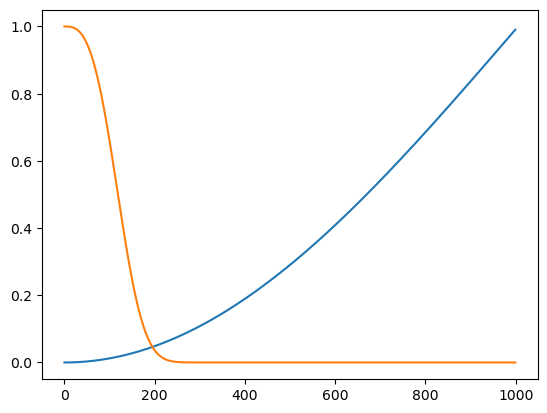

In [7]:
import numpy as np

def cosine_beta_schedule(T, s=0.008):
    """
    Generate a cosine schedule for diffusion betas.
    
    Args:
    - T (int): The total number of diffusion timesteps.
    - s (float): A small constant to ensure the betas do not reach 0, which could cause numerical stability issues.
    
    Returns:
    - np.array: An array of length T with the beta values for each timestep.
    """
    steps = np.arange(T, dtype=np.float64)
    x = s + (1 - s) * np.cos(0.5 * np.pi * steps / T)
    betas = 1 - x / x.max()
    return betas

# Example usage
T = 1000  # Total number of diffusion steps
betas = cosine_beta_schedule(T)
alphas = 1 - betas
alpha_bar = np.cumprod(alphas)
plt.plot(betas)
#plt.plot(alphas)
plt.plot(alpha_bar)
plt.show()

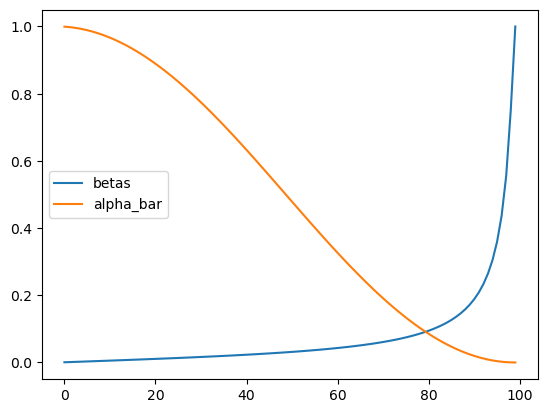

In [8]:
import torch

def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule as described in https://arxiv.org/abs/2102.09672.

    Parameters:
    - timesteps: int, the number of timesteps for the schedule.
    - s: float, small constant to prevent numerical issues.

    Returns:
    - betas: torch.Tensor, beta values for each timestep.
    - alphas: torch.Tensor, alpha values for each timestep.
    - alpha_bars: torch.Tensor, cumulative product of alphas for each timestep.
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos((x / timesteps + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return betas, alphas, alpha_bars

# Example usage
timesteps = 100  # Number of timesteps
device = 'cuda' if torch.cuda.is_available() else 'cpu'

betas, alphas, alpha_bars = cosine_beta_schedule(timesteps)
betas = betas.to(device)
alphas = alphas.to(device)
alpha_bars = alpha_bars.to(device)

import matplotlib.pyplot as plt
plt.plot(betas)
plt.plot(alpha_bars)
plt.legend(['betas', 'alpha_bar'])
plt.show()


In [9]:
import torch
import torch.nn.functional as F
T = 100

def get_diffusion_betas(spec, device):
    """Get betas from the hyperparameters."""
    
    if spec['type'] == 'linear':
        # Used by Ho et al. for DDPM, https://arxiv.org/abs/1006.11239.
        # To be used with Gaussian diffusion models in continuous and discrete
        # state spaces.
        # To be used with transition_mat_type = 'gaussian'
        return torch.linspace(spec['start'], spec['stop'], spec['num_timesteps']).to(device)
    elif spec['type'] == 'cosine':
        # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
        # To be used with transition_mat_type = 'uniform'.
        steps = torch.linspace(0, 1, spec['num_timesteps'] + 1, dtype=torch.float64)
        betas, alphas, alpha_bars = cosine_beta_schedule(spec['num_timesteps'])
        return betas.to(device)
    elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
        # To be used with absorbing state models.
        # ensures that the probability of decaying to the absorbing state
        # increases linearly over time, and is 1 for t = T-1 (the final time).
        # To be used with transition_mat_type = 'absorbing'
        return 1. / torch.linspace(spec['num_timesteps'], 1, spec['num_timesteps']).to(device)
    else:
        raise NotImplementedError(spec['type'])
    
    
def _get_gaussian_transition_mat(t):
    r"""Computes transition matrix for q(x_t|x_{t-1}).

    This method constructs a transition matrix Q with
    decaying entries as a function of how far off diagonal the entry is.
    Normalization option 1:
    Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                1 - \sum_{l \neq i} Q_{il}  if i==j.
                0                          else.

    Normalization option 2:
    tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                        0                        else.

    Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

    Args:
        t: timestep. integer scalar (or numpy array?)

    Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
    """
    num_classes = 2
    device = 'cpu'
    transition_bands = 1
    spec = {'type': 'cosine', 'start': 0.4, 'stop': 1.0, 'num_timesteps': T}
    betas = get_diffusion_betas(spec, device=device)
    # transition_bands = transition_bands if transition_bands else num_classes - 1

    beta_t = betas[t]

    mat = torch.zeros((num_classes, num_classes),
                    dtype=torch.float64).to(device, non_blocking=True)

    # Make the values correspond to a similar type of gaussian as in the
    # gaussian diffusion case for continuous state spaces.
    values = torch.linspace(torch.tensor(0.), torch.tensor(num_classes-1), num_classes, dtype=torch.float64).to(device, non_blocking=True)
    #print(values)   # [0, 1]
    values = values * 2./ (num_classes - 1.)
    #print(values)   # [0, 2]
    values = values[:transition_bands+1]
    #print(values)   # [0, 2]
    values = -values * values / beta_t
    #print(values)   # [0, -6300]
    
    # To reverse the tensor 'values' starting from the second element
    reversed_values = values[1:].flip(dims=[0])
    #print(reversed_values)  # [-6300]
    # Concatenating the reversed values with the original values
    values = torch.cat([reversed_values, values], dim=0)
    #print(values)   # [-6300, 0, -6300]
    values = F.softmax(values, dim=0)
    #print(values)   # [0, 1, 0]
    values = values[transition_bands:]
    #print(values)   # [1, 0]
    
    for k in range(1, transition_bands + 1):
        off_diag = torch.full((num_classes - k,), values[k], dtype=torch.float64).to(device, non_blocking=True)

        mat += torch.diag(off_diag, k)
        mat += torch.diag(off_diag, -k)

    # Add diagonal values such that rows and columns sum to one.
    # Technically only the ROWS need to sum to one
    # NOTE: this normalization leads to a doubly stochastic matrix,
    # which is necessary if we want to have a uniform stationary distribution.
    diag = 1. - mat.sum(dim=1)
    mat += torch.diag_embed(diag)

    return mat.to(device, non_blocking=True)

def _get_prior_distribution_transition_mat(t):
        """Computes transition matrix for q(x_t|x_{t-1}).
        Use cosine schedule for these transition matrices.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        device = 'cpu'
        spec = {'type': 'cosine', 'start': 0.4, 'stop': 0.8, 'num_timesteps': T}
        betas = get_diffusion_betas(spec, device=device)
        beta_t = betas[t]
        num_classes = 2
        class_probs = torch.tensor([1 - 5/11000, 5/11000], device=device)
        mat = torch.zeros((num_classes, num_classes), dtype=torch.float64).to(device, non_blocking=True)

        '''for i in range(num_classes):
            for j in range(num_classes):
                if i != j:
                    mat[i, j] = beta_t * class_probs[j]
                else:
                    mat[i, j] = 1 - beta_t + beta_t * class_probs[j]'''
        mat = beta_t * class_probs + (1 - beta_t) * torch.eye(2, device=device)
        
        return mat


q_one_step_mats = [_get_gaussian_transition_mat(t)
                            for t in range(0, T)]
q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to('cpu', non_blocking=True)
assert q_onestep_mats.shape == (T,
                                    2,
                                    2)

# Construct transition matrices for q(x_t|x_start)
q_mat_t = q_onestep_mats[0]
q_mats = [q_mat_t]
for t in range(1, T):
    # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
    q_mat_t = torch.tensordot(q_mat_t, q_onestep_mats[t],
                            dims=[[1], [0]])
    q_mats.append(q_mat_t)
q_mats = torch.stack(q_mats, axis=0)

for t in range(0, T, 9):
    print(q_mats[t])
    # print(_get_gaussian_transition_mat(t))
    # print(_get_prior_distribution_transition_mat(t))

'''import matplotlib.pyplot as plt

spec = {'type': 'linear', 'start': 1.0, 'stop': 100.0, 'num_timesteps': 100}
betas = get_diffusion_betas(spec, device='cpu')
plt.plot(betas)
plt.show()'''

tensor([[1., 0.],
        [0., 1.]], dtype=torch.float64)
tensor([[1., 0.],
        [0., 1.]], dtype=torch.float64)
tensor([[ 1.0000e+00, 2.7013e-181],
        [2.7013e-181,  1.0000e+00]], dtype=torch.float64)
tensor([[ 1.0000e+00, 1.1120e-119],
        [1.1120e-119,  1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 1.9474e-86],
        [1.9474e-86, 1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 5.9673e-65],
        [5.9673e-65, 1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 2.1169e-49],
        [2.1169e-49, 1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 3.3204e-37],
        [3.3204e-37, 1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 5.0076e-27],
        [5.0076e-27, 1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 4.3916e-18],
        [4.3916e-18, 1.0000e+00]], dtype=torch.float64)
tensor([[1.0000e+00, 7.1885e-10],
        [7.1885e-10, 1.0000e+00]], dtype=torch.float64)
tensor([[0.9769, 0.0231],
        [0.0231, 0.9769]], dtype=torch.f

"import matplotlib.pyplot as plt\n\nspec = {'type': 'linear', 'start': 1.0, 'stop': 100.0, 'num_timesteps': 100}\nbetas = get_diffusion_betas(spec, device='cpu')\nplt.plot(betas)\nplt.show()"

In [50]:
T = 50
def get_transition_matrix(t, device='cpu'):
    """
    Generates a 2x2 transition matrix for a discrete diffusion process at timestep t.

    Parameters:
    - t: int, current timestep.
    - device: torch.device, the device to place the tensor on.

    Returns:
    - transition_matrix: torch.Tensor, a 2x2 transition matrix.
    """
    betas, _, alpha_bars = cosine_beta_schedule(T)
    spec = {'type': 'linear', 'start': 0.00001, 'stop': 0.09, 'num_timesteps': T}
    betas = get_diffusion_betas(spec, device=device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alpha_bar_t = alpha_bars[t].to(device)
    
    # Compute the transition probabilities
    transition_matrix = torch.tensor([[alphas[t], 1 - alphas[t]],
                                      [1 - alphas[t], alphas[t]]], device=device)
    
    return transition_matrix

In [51]:
q_one_step_mats = [get_transition_matrix(t)
                            for t in range(0, T)]
q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to('cpu', non_blocking=True)
assert q_onestep_mats.shape == (T,
                                    2,
                                    2)

# Construct transition matrices for q(x_t|x_start)
q_mat_t = q_onestep_mats[0]
q_mats = [q_mat_t]
for t in range(1, T):
    # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
    q_mat_t = torch.tensordot(q_mat_t, q_onestep_mats[t],
                            dims=[[1], [0]])
    q_mats.append(q_mat_t)
q_mats = torch.stack(q_mats, axis=0)

zero_to_one = []
one_to_zero = []
for t in range(0, T, 1):
    zero_to_one.append(q_mats[t][0][1].item())
    one_to_zero.append(q_mats[t][1][0].item())
    print(q_mats[t])

tensor([[9.9999e-01, 1.0014e-05],
        [1.0014e-05, 9.9999e-01]])
tensor([[0.9981, 0.0019],
        [0.0019, 0.9981]])
tensor([[0.9945, 0.0055],
        [0.0055, 0.9945]])
tensor([[0.9890, 0.0110],
        [0.0110, 0.9890]])
tensor([[0.9818, 0.0182],
        [0.0182, 0.9818]])
tensor([[0.9730, 0.0270],
        [0.0270, 0.9730]])
tensor([[0.9625, 0.0375],
        [0.0375, 0.9625]])
tensor([[0.9506, 0.0494],
        [0.0494, 0.9506]])
tensor([[0.9374, 0.0626],
        [0.0626, 0.9374]])
tensor([[0.9229, 0.0771],
        [0.0771, 0.9229]])
tensor([[0.9074, 0.0926],
        [0.0926, 0.9074]])
tensor([[0.8909, 0.1091],
        [0.1091, 0.8909]])
tensor([[0.8737, 0.1263],
        [0.1263, 0.8737]])
tensor([[0.8558, 0.1442],
        [0.1442, 0.8558]])
tensor([[0.8375, 0.1625],
        [0.1625, 0.8375]])
tensor([[0.8189, 0.1811],
        [0.1811, 0.8189]])
tensor([[0.8002, 0.1998],
        [0.1998, 0.8002]])
tensor([[0.7814, 0.2186],
        [0.2186, 0.7814]])
tensor([[0.7628, 0.2372],
    

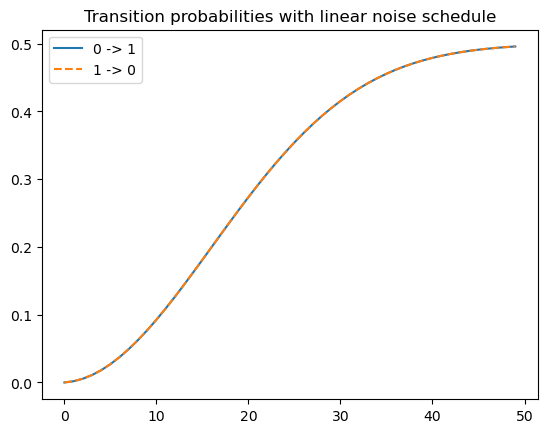

In [52]:
plt.plot(zero_to_one)
plt.plot(one_to_zero, linestyle='dashed')
plt.legend(['0 -> 1', '1 -> 0'])
plt.title('Transition probabilities with linear noise schedule')
plt.show()

In [91]:
T = 50
def _get_prior_distribution_transition_mat(t):
    """Computes transition matrix for q(x_t|x_{t-1}).
    Use cosine schedule for these transition matrices.

    Args:
    t: timestep. integer scalar.

    Returns:
    Q_t: transition matrix. shape = (num_classes, num_classes).
    """
    device = 'cpu'
    spec = {'type': 'cosine', 'start': 0.01, 'stop': 0.46, 'num_timesteps': T}
    betas = get_diffusion_betas(spec, device=device)
    beta_t = betas[t]
    num_classes = 2
    class_probs = torch.tensor([1 - 5/16000, 5/16000], device=device)
    mat = torch.zeros((num_classes, num_classes), dtype=torch.float64).to(device, non_blocking=True)

    '''for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                mat[i, j] = beta_t * class_probs[j]
            else:
                mat[i, j] = 1 - beta_t + beta_t * class_probs[j]'''
    mat = beta_t * class_probs + (1 - beta_t) * torch.eye(2, device=device)
    
    return mat

In [92]:
q_one_step_mats = [_get_prior_distribution_transition_mat(t)
                            for t in range(0, T)]
q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to('cpu', non_blocking=True)
assert q_onestep_mats.shape == (T,
                                    2,
                                    2)

# Construct transition matrices for q(x_t|x_start)
q_mat_t = q_onestep_mats[0]
q_mats = [q_mat_t]
for t in range(1, T):
    # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
    q_mat_t = torch.tensordot(q_mat_t, q_onestep_mats[t],
                            dims=[[1], [0]])
    q_mats.append(q_mat_t)
q_mats = torch.stack(q_mats, axis=0)

zero_to_one = []
one_to_zero = []
for t in range(0, T, 1):
    zero_to_one.append(q_mats[t][0][1].item())
    one_to_zero.append(q_mats[t][1][0].item())
    print(q_mats[t])

tensor([[1.0000e+00, 5.4609e-07],
        [1.7469e-03, 9.9825e-01]])
tensor([[1.0000e+00, 1.6969e-06],
        [5.4283e-03, 9.9457e-01]])
tensor([[1.0000e+00, 3.4479e-06],
        [1.1030e-02, 9.8897e-01]])
tensor([[9.9999e-01, 5.7923e-06],
        [1.8529e-02, 9.8147e-01]])
tensor([[9.9999e-01, 8.7210e-06],
        [2.7898e-02, 9.7210e-01]])
tensor([[9.9999e-01, 1.2223e-05],
        [3.9100e-02, 9.6090e-01]])
tensor([[9.9998e-01, 1.6284e-05],
        [5.2091e-02, 9.4791e-01]])
tensor([[9.9998e-01, 2.0888e-05],
        [6.6821e-02, 9.3318e-01]])
tensor([[9.9997e-01, 2.6018e-05],
        [8.3233e-02, 9.1677e-01]])
tensor([[9.9997e-01, 3.1654e-05],
        [1.0126e-01, 8.9874e-01]])
tensor([[9.9996e-01, 3.7774e-05],
        [1.2084e-01, 8.7916e-01]])
tensor([[9.9996e-01, 4.4354e-05],
        [1.4189e-01, 8.5811e-01]])
tensor([[9.9995e-01, 5.1369e-05],
        [1.6433e-01, 8.3567e-01]])
tensor([[9.9994e-01, 5.8790e-05],
        [1.8807e-01, 8.1193e-01]])
tensor([[9.9993e-01, 6.6590e-05],


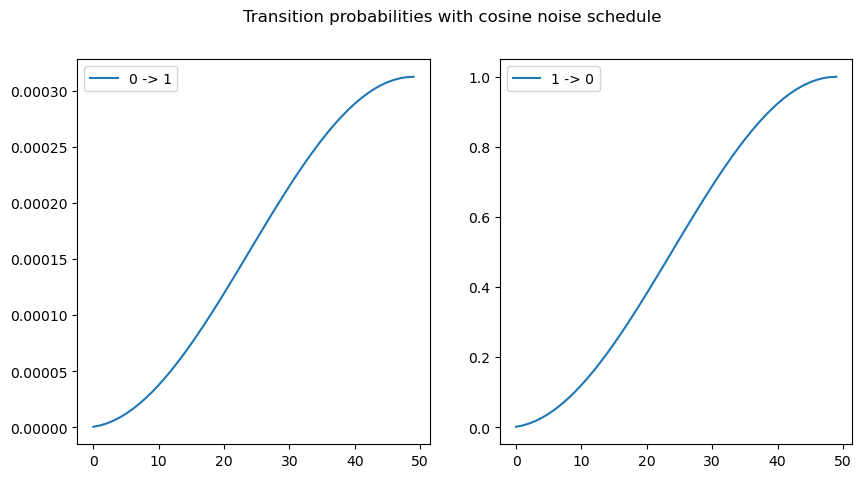

In [93]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot on the first subplot
axs[0].plot(zero_to_one, label='0 -> 1')
axs[0].legend()  # Add a legend

# Plot on the second subplot
axs[1].plot(one_to_zero, label='1 -> 0')
axs[1].legend()  # Add a legend

# Show the plot
fig.suptitle('Transition probabilities with cosine noise schedule')
plt.show()

In [60]:
print(5/16000)

0.0003125
